## Present and Future Coastal Population

Coastal Climate Core Services (CoCliCo) is an European effort to develop an opean web-platform to aid decision making on coastal risk (2021 - 2025). Please have a look at our [website](https://coclicoservices.eu/) to find out more about the project. 

During this project several datasets will be made available, which can be explored on the platform as well as accessed via cloud-storage buckets. In this notebook, some examples are provided on how to interact with the data using Python, specifically for population projections from [Merkens et al.](https://doi.org/10.1016/j.gloplacha.2016.08.009).

- Notebook author: Etiënne Kras, June 12th 2024

### Imports

In [1]:
import warnings

# import holoviews as hv
import cartopy.crs as ccrs
# import cartopy.feature as cf
import matplotlib.pyplot as plt
# import matplotlib.ticker as tck
import numpy as np
# import shapely
import pandas as pd
import folium
import pystac_client
# import xarray as xr
import rioxarray as rio
# import pathlib
import geopandas as gpd
import os
import matplotlib.cm
import branca.colormap as cm

#import colormaps as cmaps
# import pyam # https://pyam-iamc.readthedocs.io/en/latest/index.html
# import matplotlib.colors as mcolors

from copy import deepcopy
from typing import List, Dict
from shapely.geometry import shape

# ignore warnings
warnings.filterwarnings("ignore")

Cannot find header.dxf (GDAL_DATA is not defined)
C:\Users\kras\AppData\Local\Temp\ipykernel_14836\746763733.py:16: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migrati

### CoCliCo STAC catalog

In [2]:
# load the CoCliCo STAC catalog
catalog = pystac_client.Client.open(
    #"https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac/catalog.json"
    #"https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-edito/catalog.json"
    "https://minio.dive.edito.eu/project-coclico/coclico-stac-edito/catalog.json"
)
# catalog

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog.get_children())

[<CollectionClient id=floodmaps>,
 <CollectionClient id=cbca>,
 <CollectionClient id=cfr>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=slp5>,
 <CollectionClient id=slp6>,
 <CollectionClient id=coastal-mask>,
 <CollectionClient id=ceed>,
 <CollectionClient id=slp>,
 <CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=sc>,
 <CollectionClient id=NUTS_CM>,
 <CollectionClient id=NUTS>,
 <CollectionClient id=LAU>,
 <CollectionClient id=gcts>,
 <CollectionClient id=deltares-delta-dtm>,
 <CollectionClient id=coastal-grid>,
 <CollectionClient id=LAU_CM>,
 <CollectionClient id=NUTS0_CM>,
 <CollectionClient id=NUTS2_CM>,
 <CollectionClient id=pp_maps>,
 <CollectionClient id=cfhp_all_maps>,
 <CollectionClient id=cfhp_all>,
 <CollectionClient id=ceed_maps>,
 <CollectionClient id=twl_SLR>,
 <CollectionClient id=twl_SLR_RP>,
 <CollectionClient id=pp_stats>,
 <CollectionClient id=cfhp_all_stats>,
 <CollectionClien

### Load Local Administrative Units (LAU)

Note, these are not yet in the STAC so we need to load them from a local source; https://ec.europa.eu/eurostat/web/gisco/geodata/statistical-units/local-administrative-units

In [3]:
# set the path to the LAU data
LAU_path = r"p:\11207608-coclico\FASTTRACK_DATA\XX_LAU"

# read the LAU data as geoDataFrame
LAU_ds = gpd.read_file(os.path.join(LAU_path, "LAU_RG_01M_2020_4326.shp"))

In [4]:
# filter the LAU dataset on NL
LAU_ds_fil = LAU_ds[LAU_ds["CNTR_CODE"].isin(["NL"])]
#LAU_ds_fil.explore() # plot to see interactive map

# sort dataframe on population density
LAU_ds_fil = LAU_ds_fil.sort_values(by="POP_2020", ascending=False)

# filter the dataset on the most populated municipality
LAU_ds_film = LAU_ds_fil.iloc[[0]] # Amsterdam

# filter the LAU dataset on the municipalities
#LAU_ds_film = LAU_ds_fil[LAU_ds_fil["LAU_ID"] == "GM0599"] # Rotterdam

# make the plot
# f = folium.Figure(width=600, height=400)
# m = LAU_ds_film.explore().add_to(f) # plot to see interactive map
# folium.TileLayer("CartoDB positron", show=False).add_to(m)  # use folium to add alternative tiles
# folium.LayerControl().add_to(m)  # use folium to add layer control

# show map
#m

### Load Population Projections dataset

In [5]:
# define function(s)

# function to put items in dataframe
def items_to_dataframe(items: List[Dict]) -> pd.DataFrame:
    """STAC items to Pandas dataframe.

    Args:
        items (List[Dict]): _description_

    Returns:
        pd.DataFrame: _description_
    """
    _items = []
    for i in items:
        _i = deepcopy(i)
        # _i['geometry'] = shape(_i['geometry'])
        # ...  # for example, drop some attributes that you're not interested in
        _items.append(_i)
    df = pd.DataFrame(pd.json_normalize(_items))
    # for field in ["properties.datetime"]:
    #     if field in df:
    #         df[field] = pd.to_datetime(df[field])
    # df = df.sort_values("properties.datetime")
    return df

In [6]:
%%time
# read STAC items as Pandas dataframe

pop_ds = catalog.get_child("pp")
pop_ds_list = list(pop_ds.get_items()) # this is slow as we need to list all items
pop_ds_df = items_to_dataframe([i.to_dict() for i in pop_ds_list])

CPU times: total: 46.9 ms
Wall time: 437 ms


In [7]:
# filter items in datasets

# define variables
#area_list = ["UK"]  # area list to look into
yrs_list = [2010, 2030, 2050, 2100, 2150]  # years to look into 
key_list = ["CCS", "YRS", "AREA"] # filters, CCS is climate change scenario, YRS is year, AREA is area

# index AR5 dataframe on criteria
fil_idx  = []
pop_dict = {key: [] for key in key_list}
for idx, i in enumerate(pop_ds_df.id):
    area_s = str(i).split(".")[0].split("/")[-1].split("_")[-1]  # ensemble
    yrs = int(str(i).split("/")[1][0:4])  # yrs
    ccs = str(i).split("/")[0].split("SSP")[-1] # ccs
    #if area_s in area_list and 
    if yrs in yrs_list:  # constraining read ensembles and years
        pop_dict["CCS"].append(ccs)
        pop_dict["YRS"].append(yrs)
        pop_dict["AREA"].append(area_s)
        fil_idx.append(idx)

# filter pop dataframe and STAC items on index
pop_ds_df_fil = pop_ds_df.filter(items = fil_idx, axis=0)
pop_ds_fil = [pop_ds_list[i] for i in fil_idx]

### Combine LAU & Population datasets to clip the data

In [8]:
# get all items in the pop collection cropped to the selected LAU
ds_clips = []
for i in pop_ds_fil:
    pop_geom_gdf = gpd.GeoDataFrame(geometry=[shape(i.geometry)]).set_crs(i.properties["proj:code"]) # could also do with bbox
    if LAU_ds_film.geometry.iloc[0].within(pop_geom_gdf.iloc[0].geometry): # check if geometry within layer
        print(i)
        ds = rio.open_rasterio(i.assets["band_data"].href, masked=True) # open dataset
        ds_clips.append(ds.rio.clip([LAU_ds_film.geometry.iloc[0]])) # clip dataset to LAU and appends to list

<Item id=SSP1/2010/Europe_ssp1_nSLR_tot_pop.tif>
<Item id=SSP1/2030/Europe_ssp1_nSLR_tot_pop2030.tif>
<Item id=SSP1/2050/Europe_ssp1_nSLR_tot_pop2050.tif>
<Item id=SSP1/2100/Europe_ssp1_nSLR_tot_pop2100.tif>
<Item id=SSP2/2010/Europe_ssp2_nSLR_tot_pop.tif>
<Item id=SSP2/2030/Europe_ssp2_nSLR_tot_pop2030.tif>
<Item id=SSP2/2050/Europe_ssp2_nSLR_tot_pop2050.tif>
<Item id=SSP2/2100/Europe_ssp2_nSLR_tot_pop2100.tif>
<Item id=SSP5/2010/Europe_ssp5_nSLR_tot_pop.tif>
<Item id=SSP5/2030/Europe_ssp5_nSLR_tot_pop2030.tif>
<Item id=SSP5/2050/Europe_ssp5_nSLR_tot_pop2050.tif>
<Item id=SSP5/2100/Europe_ssp5_nSLR_tot_pop2100.tif>


### Define parameter space (dropdowns in the platform)

In [9]:
# set some parameters (SSP and time horizon)
ccs = "1"  # set climate change scenario for AR5
yr = 2010  # set year
area = "pop"  # set variable (note similar to Europe yet smaller in size)

### Geospatial plot

In [10]:
# make the plot

# TODO: fix the offset in the lon and lat values compared to the xarray ds_clips[0].plot() (see cell below)
for idx, (item, data) in enumerate(zip(pop_ds_fil, ds_clips)):
    #if item.id == r"SSP%s/%s/Europe_ssp%s_nSLR_tot_%s%s.tif" % (ccs, yr, ccs, area, yr):
    if item.id == r"SSP%s/%s/Europe_ssp%s_nSLR_tot_%s.tif" % (ccs, yr, ccs, area):

        pop_data = ds_clips[idx]

        lon, lat = np.meshgrid(pop_data.x, pop_data.y)
        cmap = matplotlib.cm.get_cmap('viridis')
        colormap = cm.linear.viridis.scale(vmin=np.nanmin(np.squeeze(pop_data.values)), vmax=np.nanmax(np.squeeze(pop_data.values)))
        colormap.caption = "A colormap caption"
        normed_data = (np.squeeze(pop_data.values) - np.nanmin(np.squeeze(pop_data.values))) / (np.nanmax(np.squeeze(pop_data.values)) - np.nanmin(np.squeeze(pop_data.values)))
        colored_data = cmap(normed_data)


        print(item.id)
        # f = folium.Figure(width=600, height=400)
        # m = LAU_ds_film.explore(style_kwds=dict(weight=1, opacity=0.4, fillOpacity=.4)).add_to(f) # plot to see interactive map
        # folium.raster_layers.ImageOverlay(colored_data,
        #                     [[lat.min(), lon.min()], [lat.max(), lon.max()]],
        #                     mercator_project=True, style_kwds=dict(weight=2),
        #                     opacity=0.5).add_to(m)
        # folium.TileLayer("CartoDB positron", show=True).add_to(m)  # use folium to add alternative tiles
        # folium.LayerControl().add_to(m)  # use folium to add layer control
        # m.add_child(colormap)

# show map
#m

SSP1/2010/Europe_ssp1_nSLR_tot_pop.tif


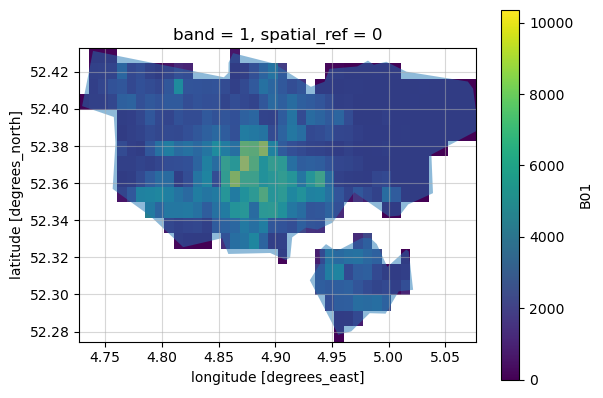

In [11]:
#%matplotlib ipympl
%matplotlib inline

fig, ax = plt.subplots() #figsize=(16, 9)
pop_data.plot(ax=ax)
LAU_ds_film.plot(ax=ax, alpha=0.5)
plt.grid(alpha=0.5)

### Compute statistics

In [ ]:
# compute statistics

# people living in the LAU (pop count per cell)
for idx, (item, data) in enumerate(zip(pop_ds_fil, ds_clips)):
    if item.id == r"SSP%s/%s/SSP%s_%s_%s.tif" % (ccs, yr, ccs, yr, area):

        print("number of people living in %s for SSP%s in %s: %s"%(LAU_ds_film.LAU_NAME.values[0], ccs, yr, np.int(np.nansum(data.values))))

### Temporal plot

In [ ]:
def bar_plot(ax, data, xticks=None, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    xticks: array-like, optional
        Xticks for the plot

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if xticks is None:
        xdata = np.arange(len(data[list(data)[0]]))
    else:
        xdata = xticks

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in zip(xdata, values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)], alpha=0.8)

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

In [ ]:
# plot in time, i.e. retrieve all data

# get the data
summed_pop = {key: [] for key in ["SSP1", "SSP2", "SSP5"]}
summed_pop_yrs = []
for idx, (item, data) in enumerate(zip(pop_ds_fil, ds_clips)):
    area_s = str(item).split(".")[0].split("/")[-1].split("_")[-1]  # ensemble
    yrs = int(str(item).split("/")[1][0:4])  # yrs
    ccs = str(item).split("/")[0].split("SSP")[-1] # ccs
    summed_pop["SSP%s"%ccs].append(np.int(np.nansum(data.values)))
    summed_pop_yrs.append(yrs)

# make the plot
fig, ax = plt.subplots(figsize=(9,5))
bar_plot(ax, summed_pop, xticks=summed_pop_yrs, colors=["green", "blue", "red"], total_width=15, single_width=0.9)
#ax.set_xticks(summed_pop_yrs)
ax.set_xlabel("Time")
ax.set_ylabel("Number of people")
ax.set_title("Narratives for population evolution at %s"%(LAU_ds_film.LAU_NAME.values[0]))
ax.set_xticks(summed_pop_yrs)
ax.set_xlim(summed_pop_yrs[0]-15/2, summed_pop_yrs[-1]+15/2)
ax.grid(alpha=0.5)
plt.show()